In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [2]:
# Load raw data
train_feat = pd.read_csv('train_features.csv')
train_sal = pd.read_csv('train_salaries.csv')
test_feat = pd.read_csv('test_features.csv')

# kiểm tra data
train_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [3]:
train_sal.head()


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [4]:
test_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [5]:
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

(1000000, 8)
(1000000, 2)
(1000000, 8)


In [6]:
train_data = pd.merge(train_feat, train_sal, on ='jobId')

# Check features of merged data (kiểm tra đồng nhất dữ liệu )
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
train_data.shape

(1000000, 9)

In [8]:
# Check for missing data(kiểm tra dữ liệu có bị thiếu không )
missing_data = train_data.isnull().sum()
missing_data

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [9]:
# Check for invalid salaries (kiểm tra xem có lương =0 không ?)
zero_salary = train_data['salary']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [10]:
# Define categorical variables
train_data['jobId']=pd.Categorical(train_data['jobId'])
train_data['companyId']=pd.Categorical(train_data['companyId'])
train_data['jobType']=pd.Categorical(train_data['jobType'])
train_data['degree']=pd.Categorical(train_data['degree'])
train_data['major']=pd.Categorical(train_data['major'])
train_data['industry']=pd.Categorical(train_data['industry'])
train_data.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [11]:
# Thống kê dữ liệu
train_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [12]:
# Unique values in train_data
train_data.nunique()

jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
salary                     280
dtype: int64

In [13]:
# xác định hệ số tương quan của dữ liệu 
train_data.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


In [14]:
# ????

In [15]:
# Thiết lập lại dữ liệu vì ID công việc và ID công ty sẽ không ảnh hưởng đến lương nên loại bỏ bớt 

In [16]:
# xóa đi các trường không cần thiết 
train_data = train_data.drop('jobId', axis = 1)
train_data = train_data.drop('companyId', axis = 1)
test_feat = test_feat.drop('jobId', axis = 1)
test_feat = test_feat.drop('companyId', axis = 1)

In [17]:
#One hot encode categorical data in the dataset
train_data = pd.get_dummies(train_data)
train_data.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


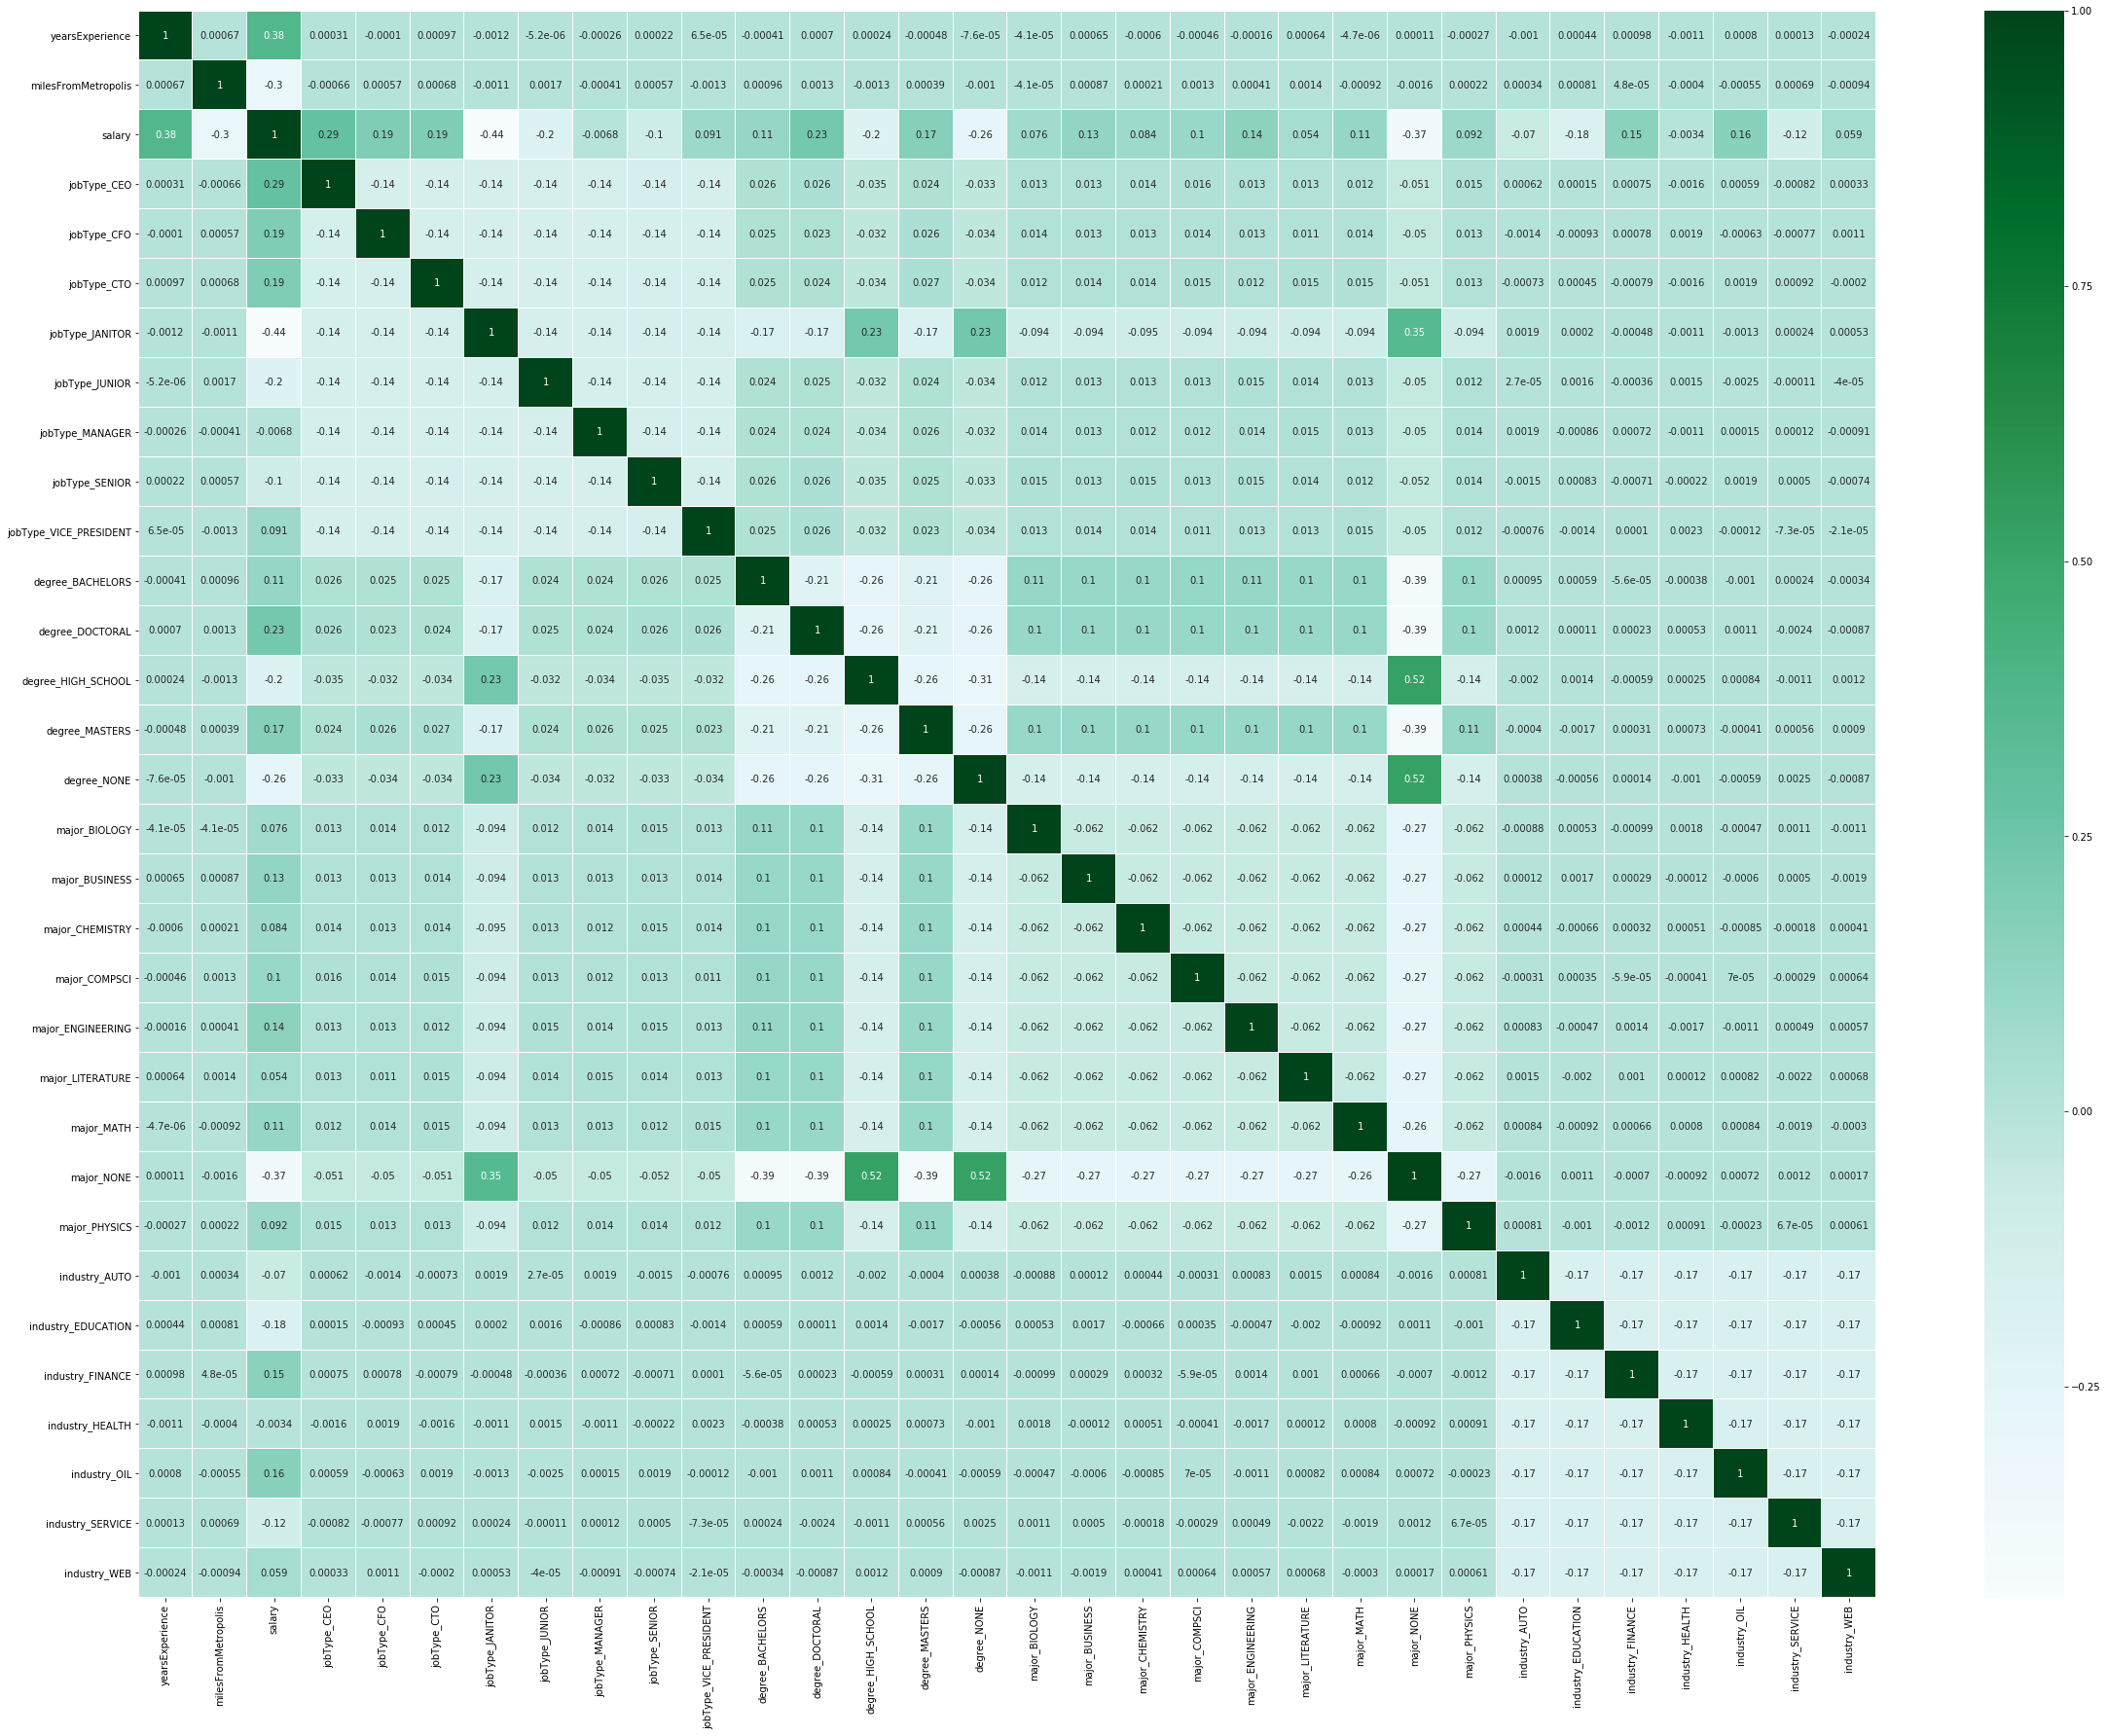

In [18]:
# Sự tương quan giữa tất cả các tính năng khác nhau sẽ được trình bày bằng ma trận

plt.subplots(figsize = (40, 30))
sns.heatmap(train_data.corr(), cmap = 'BuGn', linewidth = 0.005, annot = True)

In [19]:
# Rất rõ ràng rằng Kinh nghiệm (Năm) có mối tương quan cao nhất với Mức lương.
# Các vai trò công việc khác như của CFO, CTO và CEO cũng cho thấy mối tương quan cao với Mức lương. 
# Bằng cấp Doctorol có tương quan với mức lương cao hơn

In [20]:

x = train_data.drop('salary', axis = 1)
    

y = train_data['salary']

In [21]:
# chia data để train và test tỷ lệ 80:20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=True)

print("Số lượng mẫu đào tạo:",x_train.shape[0])
print("Số lượng mẫu test :", x_test.shape[0])

Số lượng mẫu đào tạo: 800000
Số lượng mẫu test : 200000


In [22]:
# sử dụng thuật toán hồi quy tuyến tính

In [23]:
# tạo đối tượng Linear Regressor
lr = LinearRegression()

# tạo đối tượng Logistic Regressor
# lr= LogisticRegression() 

lr.fit(x_train, y_train)

# đưa ra dự đoán cho 5 mức lương đầu tiên
y_hat = lr.predict(x_test)
print("5 mức lương đầu tiên là : ", y_hat[0:5])

5 mức lương đầu tiên là :  [ 65.890625   152.92129517 130.9079895  107.78588867 113.09985352]


In [24]:
# Linear function:$$ Yhat = a + b x
print("b: ", lr.coef_)
print("a: ", lr.intercept_)

b:  [ 2.00895828e+00 -4.00066860e-01  1.50185244e+11  1.50185244e+11
  1.50185244e+11  1.50185244e+11  1.50185244e+11  1.50185244e+11
  1.50185244e+11  1.50185244e+11 -2.02638489e+10 -2.02638489e+10
 -2.02638489e+10 -2.02638489e+10 -2.02638489e+10 -2.03533099e+10
 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10
 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10
  3.89286669e+10  3.89286669e+10  3.89286669e+10  3.89286669e+10
  3.89286669e+10  3.89286669e+10  3.89286669e+10]
a:  -148496751768.4715


In [25]:
# kiểm tra thử
y_hat=lr.predict(x_test) 
y_hat

array([ 65.890625  , 152.92129517, 130.9079895 , ..., 112.82815552,
        56.73425293, 128.84353638])

In [26]:
#kiểm tra độ chính xác 
print('The R-square is: ', lr.score(x,y))

The R-square is:  0.7435332993594033


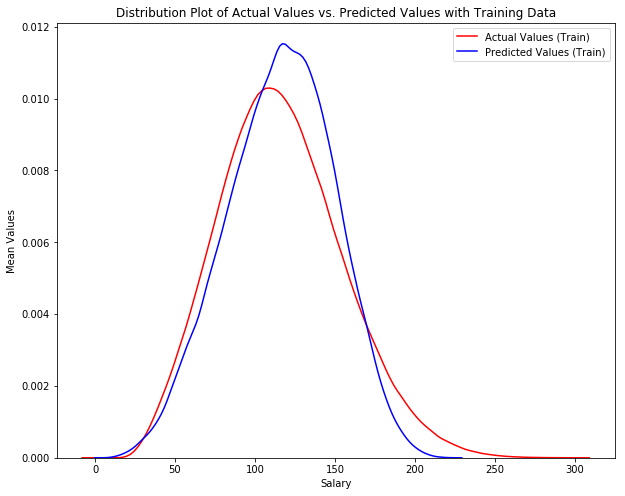

In [27]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 10
    height = 8
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Salary')
    plt.ylabel('Mean Values')
    plt.show()
    plt.close()

#Distribution plot for the 80% train data
Title = 'Distribution Plot of Actual Values vs. Predicted Values with Training Data'
DistributionPlot(y_train, y_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [28]:
# sử dụng Logistic Regressor

In [29]:
# tạo đối tượng Logistic Regressor
lgr = LogisticRegression() 

lgr.fit(x_train, y_train)

KeyboardInterrupt: 